In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///Resources/hawaiiV2.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [17]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11cd3fe80>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [19]:
# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
# results

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns=['date', 'precipitation'])
results_df.set_index('date', inplace=True)

# Sort the dataframe by date
results_df = results_df.sort_values(by='date', ascending=True)
results_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [20]:
# Convert df to dictionary
results_df_dict = results_df.reset_index().to_dict('records')

In [21]:
# Convert dictionary to JSON
import json
json.dumps(results_df_dict, indent=4)

'[\n    {\n        "date": "2016-08-23",\n        "precipitation": 0.0\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": NaN\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": 1.79\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": 0.05\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": 0.15\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": 0.7\n    },\n    {\n        "date": "2016-08-23",\n        "precipitation": 0.02\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": 0.08\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": 2.15\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": 2.28\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": NaN\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": 1.45\n    },\n    {\n        "date": "2016-08-24",\n        "precipitation": 1.22\n    },\

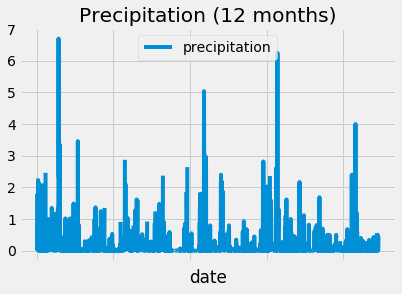

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [24]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Measurement.station).distinct().count()
stations_available

9

In [25]:
# All stations
all_stations = session.query(Station.station).all()
all_stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,
                                func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).\
                                desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Most active station
m_active_station=active_stations[0][0]
m_active_station

'USC00519281'

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_temps = session.query(*sel).filter(Measurement.station == m_active_station).all()
#         order_by(Measurement.tobs).all()
active_temps
print(f"Low: {active_temps[0][0]}, High: {active_temps[0][1]}, Average: {round(active_temps[0][2],2)}")

Low: 54.0, High: 85.0, Average: 71.66


In [29]:
# Choose the station with the highest number of temperature observations.
most_temps_obv = session.query(Measurement.station, func.count(Measurement.tobs)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.tobs).desc())
most_temps_obv = most_temps_obv[0]
most_temps_obv

('USC00519281', 2772)

In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(prev_year)
results_most_temps = session.query(Measurement.tobs).\
                    filter(Measurement.date >= prev_year).\
                    filter(Measurement.station == most_temps_obv[0]).all()
# results_most_temps

results_most_temps_df = pd.DataFrame(results_most_temps, columns=['tempurature'])
results_most_temps_df.head()

2016-08-23


,tempurature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


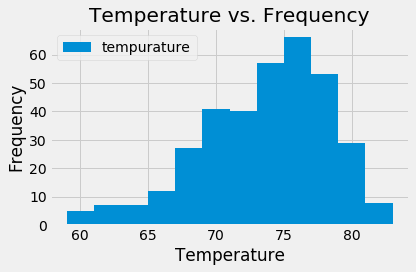

In [31]:
# Create a histogram of the precipitation measurements
results_most_temps_df.plot.hist(bins=12, title="Temperature vs. Frequency")
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig("Images/Temperature_vs_Frequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    # Query the min, avg, and max temps
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Use function with dates provided
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-02-28','2017-03-05')
trip

[(64.0, 72.02777777777777, 78.0)]

In [34]:
# Create a dataframe to store these values
trip_df = pd.DataFrame(trip, columns=['Min', 'Avg', 'Max'])
trip_df

,Min,Avg,Max
0,64.0,72.027778,78.0


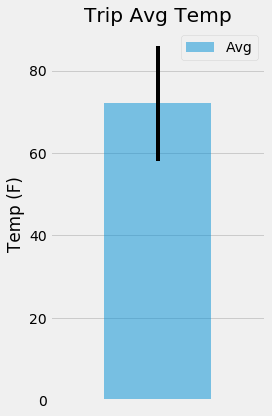

In [35]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df.plot.bar(y='Avg', yerr=(trip_df['Max'] - trip_df['Min']), title='Trip Avg Temp', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()

In [36]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation (start_date, end_date):
    """Precipitation information for each station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        Precipitation amount, station, name, latitude, longitude, and elevation
    """
    
    # Query
    
    sel = [Measurement.station,
          Station.name,
          Station.latitude,
          Station.longitude,
          Station.elevation,
          Measurement.prcp]
    
    return session.query(*sel).\
        filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-02-28','2017-03-05'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.41), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.35), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.35), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.14), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


In [37]:
# Start date for Flask activity

from_start = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= '2017-02-28').\
    group_by(Measurement.date).all()
from_start

[('2017-02-28', 69.0, 72.28571428571429, 74.0),
 ('2017-03-01', 64.0, 69.0, 73.0),
 ('2017-03-02', 72.0, 73.16666666666667, 75.0),
 ('2017-03-03', 69.0, 72.71428571428571, 78.0),
 ('2017-03-04', 70.0, 74.8, 77.0),
 ('2017-03-05', 68.0, 70.5, 73.0),
 ('2017-03-06', 66.0, 69.71428571428571, 76.0),
 ('2017-03-07', 62.0, 68.0, 74.0),
 ('2017-03-08', 64.0, 69.0, 74.0),
 ('2017-03-09', 67.0, 69.28571428571429, 72.0),
 ('2017-03-10', 65.0, 68.42857142857143, 75.0),
 ('2017-03-11', 68.0, 76.6, 82.0),
 ('2017-03-12', 69.0, 73.4, 80.0),
 ('2017-03-13', 66.0, 70.14285714285714, 77.0),
 ('2017-03-14', 67.0, 72.42857142857143, 77.0),
 ('2017-03-15', 69.0, 72.16666666666667, 76.0),
 ('2017-03-16', 66.0, 71.28571428571429, 77.0),
 ('2017-03-17', 68.0, 70.5, 72.0),
 ('2017-03-18', 65.0, 70.16666666666667, 76.0),
 ('2017-03-19', 72.0, 73.4, 74.0),
 ('2017-03-20', 69.0, 73.66666666666667, 77.0),
 ('2017-03-21', 72.0, 73.83333333333333, 76.0),
 ('2017-03-22', 72.0, 74.0, 76.0),
 ('2017-03-23', 70.0, 73.1

In [38]:
# Start and End date for Flask activity

start_end = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= '2016-02-28').\
    filter(Measurement.date <= '2017-03-05').\
    group_by(Measurement.date).all()
start_end

[('2016-02-28', 66.0, 71.33333333333333, 80.0),
 ('2016-02-29', 67.0, 71.16666666666667, 79.0),
 ('2016-03-01', 68.0, 71.71428571428571, 73.0),
 ('2016-03-02', 63.0, 68.28571428571429, 71.0),
 ('2016-03-03', 63.0, 68.42857142857143, 72.0),
 ('2016-03-04', 62.0, 68.33333333333333, 75.0),
 ('2016-03-05', 66.0, 70.2, 76.0),
 ('2016-03-06', 68.0, 71.0, 76.0),
 ('2016-03-07', 63.0, 69.28571428571429, 78.0),
 ('2016-03-08', 72.0, 75.42857142857143, 78.0),
 ('2016-03-09', 66.0, 68.14285714285714, 74.0),
 ('2016-03-10', 67.0, 69.28571428571429, 71.0),
 ('2016-03-11', 66.0, 70.14285714285714, 72.0),
 ('2016-03-12', 70.0, 72.16666666666667, 73.0),
 ('2016-03-13', 69.0, 71.75, 74.0),
 ('2016-03-14', 67.0, 71.85714285714286, 77.0),
 ('2016-03-15', 66.0, 68.33333333333333, 71.0),
 ('2016-03-16', 68.0, 71.71428571428571, 78.0),
 ('2016-03-17', 65.0, 68.33333333333333, 70.0),
 ('2016-03-18', 66.0, 69.0, 71.0),
 ('2016-03-19', 67.0, 69.6, 72.0),
 ('2016-03-20', 68.0, 71.8, 75.0),
 ('2016-03-21', 66.0,

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
